# Differential gene targeting of pancreatic cancer subtypes
Author: Deborah Weighill<sup>1</sup>, Marouen Ben Guebila<sup>1</sup>

<sup>1</sup> Department of Biostatistics, Harvard T.H. Chan School of Public Health, Boston, MA.

# Introduction

Pancreatic ductal adenocarcinoma (PDAC)  is the fourth leading leading cause of cancer worldwide <sup>1</sup>, with few efficient therapeutic options. In fact, PDAC is a highly hetergenous disease, this is why one size fits all approach to treatment have provided limited success so far. Therefore, subtype identification is necessary to tailor therapeutic approaches to the specific molecular characteristic of disease progression in each patient.

Recent work<sup>2,3</sup> has identified novel subtypes in PDAC by the virtual dissection of the genomic markers. It has been shown that gene expression is an informative feature in classifying patients<sup>4</sup>. In addition, gene regulation could play a major role in the emergence of distinct phenotypes in PDAC. Therefore, modeling regulatory features in PDAC could provide a novel approach to stratify patients and provide tailored therapeutic apporaches.

![https://www.pancreaticcancer.org.uk/information/just-diagnosed-with-pancreatic-cancer/types-of-pancreatic-cancer/](https://www.pancreaticcancer.org.uk/wp-content/uploads/2020/09/anatomy-of-pancreas-final-sept-2016-1-1024x676.jpg)

In this analysis, we will investigate regulatory hetergeneity in PDAC subtypes by building sample-specific gene regulatory networks using gene expression data from TCGA<sup>5</sup> and compute a network metric called the gene targeting score to identify differentially regulated genes between basal-like and classical subtypes.

Networks computed in this analysis are available through GRAND database: https://grand.networkmedicine.org/cancers/PAAD_cancer/

# Loading data and libraries
This tutorial can be run on the server or locally by setting the following parameter:

In [ ]:
runserver=1

Also, some parts of the notebook might take some time to compute, therefore, we use the following parameter to load precomputed results.

In [ ]:
precomputed=1

When the notebook is executed locally, we need to install the dependencies packages first including the [netZooR package](netzoo.github.io) that includes gene regulatory network analysis functions.

In [ ]:
if(runserver==0){
    install.packages("devtools") 
    library(devtools)
    ppath=''
}else if(runserver==1){
    ppath='/opt/data/tttutorial/'
}

Then, we install netZooR package with vignettes, otherwise please remove the `build_vignettes = TRUE` argument.

In [ ]:
devtools::install_github("netZoo/netZooR", build_vignettes = TRUE)

Then, we can load the packages that are needed for the analysis.

In [ ]:
library(netZooR) # To use network reconstruction methods PANDA and LIONESS
library(recount) # To use processed gene expression data 
library(limma)   # To compute differential targeting 
library(tidyr)
library(data.table)

We will call the Python implementation of the network analysis methods, so we need to tset the Python path. Please replace the path in the reticulate command use_python with your Python installation path.

In [ ]:
if(runserver==0){
    use_python("/home/ubuntu/.local/bin/venv/bin/python3") 
}else if(runserver==1){
    Sys.setenv(RETICULATE_PYTHON = "/opt/anaconda3/py38/bin/python") 
}

## Load gene expression data
Now, let's load TCGA PDAC gene expression data, which was obtained from [recount2](https://jhubiostatistics.shinyapps.io/recount/)<sup>6</sup>. The recount project has processed all the publicly availble gene expression data using a uniform pipeline, which allows to control the variance between the studies and extract biological signal with minimal interference of effects due to the read alignment method.

In [ ]:
load(paste0(ppath,"rse_gene_pancreas.Rdata"))

First, we need to to normalize the counts to consider the coverage of all the samples using the Transcript Per Million method (TPM). This method takes into account sequencing depth and gene length to normalize gene expression<sup>7</sup>.

In [ ]:
TPM <- getTPM(rse_gene, length_var = "bp_length", mapped_var = 'mapped_read_count')

Then, we remove transcript number from gene names.

In [ ]:
rownames(TPM)<-sub("\\.[0-9]*","", rownames(TPM))

Next, we need to map TCGA ID to samples and further clean the metadata.

In [ ]:
metadata <- rse_gene@colData

We keep the phenotypic variables we are interested in.

In [ ]:
metadata <- metadata[,c("gdc_cases.samples.portions.analytes.aliquots.submitter_id","gdc_cases.demographic.gender","gdc_cases.demographic.race","gdc_cases.demographic.ethnicity","gdc_cases.exposures.weight","gdc_cases.exposures.height","gdc_cases.project.primary_site","gdc_cases.diagnoses.primary_diagnosis","cgc_case_age_at_diagnosis","gdc_cases.diagnoses.tumor_stage","gdc_cases.diagnoses.days_to_death","gdc_cases.diagnoses.vital_status")]

Then, we extract sample informatio from the ID to identify subtypes at later stages and tease out normal samples from cacner samples.

In [ ]:
metadata$rnaseq_column <- rownames(metadata)
metadata <- separate(data.frame(metadata), gdc_cases.samples.portions.analytes.aliquots.submitter_id, c("proj", "tss", "participant", "sample","portion","plate","center"), "-",remove = FALSE)
metadata$sampletype <- as.numeric(substr(metadata$sample,1,2))
colnames(TPM) <- metadata$gdc_cases.samples.portions.analytes.aliquots.submitter_id[match(colnames(TPM),metadata$rnaseq_column)]

# Extract samples with subtypes

TCGA includes samples taken from the site of tumor but also samples from the healthy tissues around the tumor. These samples are called adjacent normal samples and we need to process the data to remove them from our analysis.

Using TCGA barcodes (see https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/), we extract only samples corresponding to tumor (i.e. removing adjacent normal tissue). According the TCGA doucumentation, for each sample tumor types are given a sample id from 01 - 09, normal types from 10 - 19 and control samples from 20 - 29. Then, we start by extracting the sample information from the TCGA id. 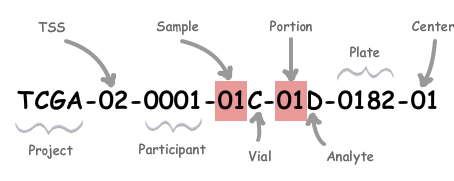
For example TCGA-FB-AAPU-01A-31R-A41B-07, has a sample id of 01, which means it is a tumor sample. To get all tumor samples and filter out the control and adjacent normal samples, we check that their sample id is between 01-09.

In [ ]:
metadata$tumor <- ifelse(((metadata$sampletype >= 1) & (metadata$sampletype <= 9)),"tumor","non_tumor")

Then, we keep only the tumor samples.

In [ ]:
tumor_samples <- metadata$gdc_cases.samples.portions.analytes.aliquots.submitter_id[which(metadata$tumor == "tumor")]
selected_samples_pdac <- TPM[,tumor_samples]
metadata <- metadata[which(metadata$tumor == "tumor"),]

Now we need to convert gene expression data into a data frame to be able to work with it in the network modeling step. Also, we need to annotate the columns and rows of the expression matrix.

In [ ]:
samples <- as.data.frame(tumor_samples)
colnames(samples) <- "sampleID"

Then, just like we did for metadata, we will decode the sample ID to extract information about sample origin for downstream analyses.

In [ ]:
samples <- separate(samples, sampleID, c("proj", "tss", "participant","sample","portion","plate","center"), "-", remove = FALSE)
samples$shorterID  <- paste(samples[,2],samples[,3],samples[,4],samples[,5], sep = "-")
metadata$shorterID <- samples$shorterID
colnames(selected_samples_pdac) <- samples$shorterID

We now load the previously annotated file of the molecular subtypes of the samples, as determined in Moffit et al.<sup>3</sup>. We narrow down our samples to those assigned a subtype. In this example, we focus on genes which vary in their expression the most, and thus chose those with $std(logTPM) \geq 0.4$. If one has access to enough memory and computational time, one can use the whole genome.

First, we start by loading and exploring the subtype assignment file.

In [ ]:
sample_subtypes <- read.table(ppath(,"subtypes.txt"), header = FALSE)
colnames(sample_subtypes) <- c("sample","subtype")
head(sample_subtypes)

Then, we filter the samples based on the criteria we specified earlier. First, we start by adding the sample type in the metadata variable.

In [ ]:
subtype_samples <- as.vector(sample_subtypes$sample[which(!(is.na(sample_subtypes$subtype)))])
indSelec=match(subtype_samples, metadata$shorterID)
metadata=metadata[indSelec,]
metadata$subtype=as.vector(sample_subtypes$subtype[which(!(is.na(sample_subtypes$subtype)))])

Then, we select the data TPM values corresponding to each subtype and taking the samples that have more than 1 count.

In [ ]:
tpms_selected_samples <- selected_samples_pdac[,subtype_samples]
rowsums <- apply(data.matrix(tpms_selected_samples),MARGIN = 1, FUN = sum)
tpms_selected_samples_genes <- tpms_selected_samples[names(which(rowsums != 0)),]

Then, we filter using the criteria presented above.

In [ ]:
logtpms_selected_samples_genes <- log10(data.matrix(tpms_selected_samples_genes))
sdev <- apply(data.matrix(logtpms_selected_samples_genes),MARGIN = 1, FUN = sd)
logtpms_selected_samples_genes_sd <- logtpms_selected_samples_genes[names(which(sdev >= 0.4)),]
write.table(logtpms_selected_samples_genes_sd,file = "../data/pdac_expression_sd_log_04.txt", row.names = TRUE, col.names = FALSE, quote=FALSE,sep = "\t")

# Network analysis

## Reconstruction of single-sample gene regulatory networks
Now, we build an aggregate gene regulatory network for all the 150 patient samples in the dataset using PANDA<sup>8</sup>. Then we infer a single-sample network from the single-sample expression and the aggregate network using LIONESS<sup>9</sup>.

These methods take as input three data types: the gene expression data from TCGA, a naive motif prior (generated from FIMO<sup>10</sup> scans of the human genome), and a protein-protein interaction network from STRINGdb<sup>11</sup>. The PPI and motif prior network were processed as in [Sonawane et al.](https://doi.org/10.1016/j.celrep.2017.10.001)<sup>12</sup>.

We will call the `lioness.py` function here, which will call PANDA underneath the hood. This is a Python implementation that is called from R using the `reticulate` package, so make sure that Python path is correctly speicifed in the `use_python` command. Otherwise, please check the README file of [netZooR](https://github.com/netZoo/netZooR) for detailed instructions.

This step might take a bit of time to compute, so we can directly load the precomputed results.

In [ ]:
if(precomputed==0){
    lioness_pdac <- lioness.py(expr_file = "/opt/data/tttutorial/pdac_expression_sd_log_04.txt" , motif_file = "/opt/data/tttutorial/motif_prior.txt", ppi_file = "/opt/data/tttutorial/tissues_ppi.txt")
}else if(precomputed==1){    
    load(paste0(ppath,"lioness_pdac.RData"))
}

In [ ]:
The structure of the result dataframe 

In [ ]:
lioness_pdac

These networks can be downloaded from [GRAND database](http://grand.networkmedicine.org/cancers/).

## Calculate gene targeting score
Now, for each gene in each sample-specific network, we calculate the gene targeting score as the degree (sum of adjacent edge weights) in that sample's network.

In [ ]:
sample_order <- colnames(logtpms_selected_samples_genes_sd)
subtype_order <- sample_subtypes$subtype[match(sample_order,sample_subtypes$sample)]
subtype_order_names <- ifelse(subtype_order == 1,"basal","classical")
colnames(lioness_pdac) <- c("TF","Gene",sample_order)
geneTargetting <- aggregate(. ~ Gene, lioness_pdac[-1], sum)

We've also recorded which samples belong to each subtype to be able to do differential analyssis based on these groups in the next section.

## Differential targeting
Finally, we use limma<sup>13</sup> ([Ritchie et al.](https://doi.org/10.1093/nar/gkv007)) to identify differentially targeted genes between basal-like and classical samples, i.e., the genes that have a differential targeting score in each of the subtype. We start first by building the design matrix that indicates the subtype membership of each sample.

In [ ]:
gene_targetting_matrix <- geneTargetting[,c(2:151)]
rownames(gene_targetting_matrix) <- rownames(geneTargetting)
subtype <- as.factor(subtype_order_names)
design <- model.matrix(~subtype)

Then, we compute differential trageting using the design matrix and the gene targeting score matrix.

In [ ]:
fit = lmFit(as.matrix(gene_targetting_matrix),design)
fit = eBayes(fit)

Then, we can build our result table and see which genes are differentially targeted across samples.

In [ ]:
adjustedTarg      <- topTable(fit, number = Inf, adjust = "fdr", coef = "subtypeclassical")
adjustedTarg$Gene <- geneTargetting$Gene[as.numeric(rownames(adjustedTarg))]
head(adjustedTarg)

This table contains summary statistic such as log fold change (logFC) between subtypes, p-values and multiple-testing corrected p-values, the average targeting in the `AveExp` column, and finally the t-statistic and the Beta values.

# Conclusion
A complete biological interpretation of the results and the rationale behind the use of targeting in finding differential regulatory patterns is described in [our publication](https://arxiv.org/abs/2101.03985) that comes with this tutorial. In particular, we showed that targeting as a network score can reveal new biological insights not covered by either coexpression networks or by differential gene expression analysis.

# References

1- Adamska, Aleksandra, Alice Domenichini, and Marco Falasca. "Pancreatic ductal adenocarcinoma: current and evolving therapies." International journal of molecular sciences 18.7 (2017): 1338.

2- Rashid, Naim U., et al. "Purity independent subtyping of tumors (PurIST), A clinically robust, single-sample classifier for tumor subtyping in pancreatic cancer." Clinical Cancer Research 26.1 (2020): 82-92.

3- Moffitt, Richard A., et al. "Virtual microdissection identifies distinct tumor-and stroma-specific subtypes of pancreatic ductal adenocarcinoma." Nature genetics 47.10 (2015): 1168.

4- Diaferia, Giuseppe R., et al. "Dissection of transcriptional and cis‐regulatory control of differentiation in human pancreatic cancer." The EMBO journal 35.6 (2016): 595-617.

5- Weinstein, John N., et al. "The cancer genome atlas pan-cancer analysis project." Nature genetics 45.10 (2013): 1113.

6- Collado-Torres, Leonardo, et al. "Reproducible RNA-seq analysis using recount2." Nature biotechnology 35.4 (2017): 319-321.

7- Li, Bo, et al. "RNA-Seq gene expression estimation with read mapping uncertainty." Bioinformatics 26.4 (2010): 493-500.

8- Glass, Kimberly, et al. "Passing messages between biological networks to refine predicted interactions." PloS one 8.5 (2013): e64832.

9- Kuijjer, Marieke Lydia, et al. "Estimating sample-specific regulatory networks." Iscience 14 (2019): 226-240.

10- Grant, Charles E., Timothy L. Bailey, and William Stafford Noble. "FIMO: scanning for occurrences of a given motif." Bioinformatics 27.7 (2011): 1017-1018.

11- Szklarczyk, Damian, et al. "STRING v11: protein–protein association networks with increased coverage, supporting functional discovery in genome-wide experimental datasets." Nucleic acids research 47.D1 (2019): D607-D613.

12- Sonawane, Abhijeet Rajendra, et al. "Understanding tissue-specific gene regulation." Cell reports 21.4 (2017): 1077-1088.

13- Ritchie, Matthew E., et al. "limma powers differential expression analyses for RNA-sequencing and microarray studies." Nucleic acids research 43.7 (2015): e47-e47.

14- Weighill, Deborah, et al. "Gene targeting in disease networks" arXiv 2101.03985 (2021). https://arxiv.org/abs/2101.03985


## Image credit 

https://www.pancreaticcancer.org.uk/information/just-diagnosed-with-pancreatic-cancer/types-of-pancreatic-cancer/